In [1]:
import pandas as pd
import sqlite3
import sys
sys.path.append("..")
import seaborn as sns
color_pal = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
color_map = pd.read_csv("../src/fpl/pipelines/model_pipeline/team_mapping.csv")
color_map = color_map.set_index("FBREF_NAME")["PRIMARY_COLOR"].to_dict()

In [27]:
def plot_elos(team_df, x_axis, y_axis, tooltips):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
    for i, axis in enumerate(x_axis):
        sns.scatterplot(x=axis, y=y_axis, data=team_df, ax=axes[i], palette=color_map, hue="OPPONENT", legend=None)
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, markerfacecolor=value, markersize=8) for key, value in color_map.items()]
    fig.legend(handles=legend_elements, loc='center right', title='Opponent')
    plt.subplots_adjust(right=0.85)

    fig.show()

C:\Users\ongmi\AppData\Local\Temp\ipykernel_23920\2869332666.py:10: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



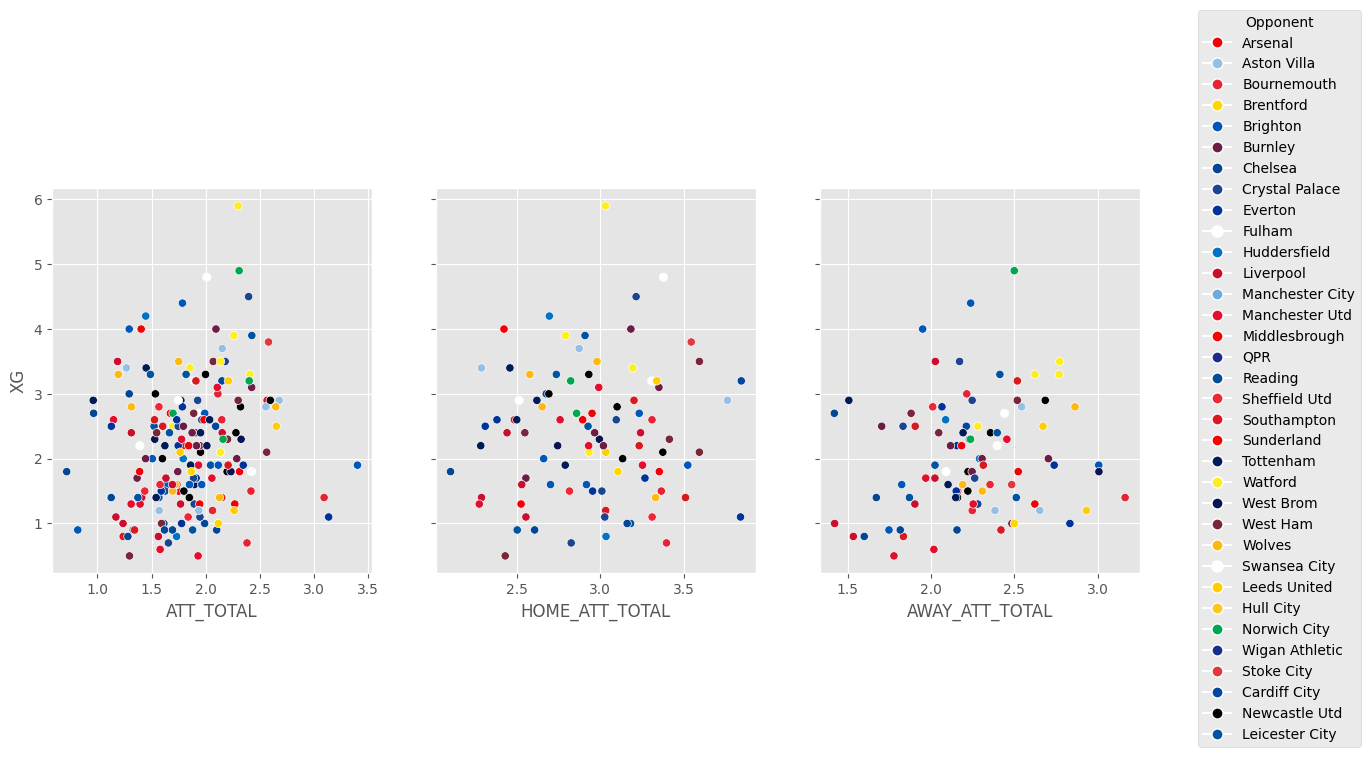

In [28]:
with sqlite3.connect('../data/fpl.db') as con:
    processed_data = pd.read_sql_query('select * from "02_PROCESSED_DATA"', con)
team_df = processed_data[processed_data["TEAM"]=="Manchester City"].copy()
plot_elos(
    team_df, 
    ["ATT_TOTAL", "HOME_ATT_TOTAL", "AWAY_ATT_TOTAL"], 
    "XG", 
    ["OPPONENT", "SEASON", "ROUND"])

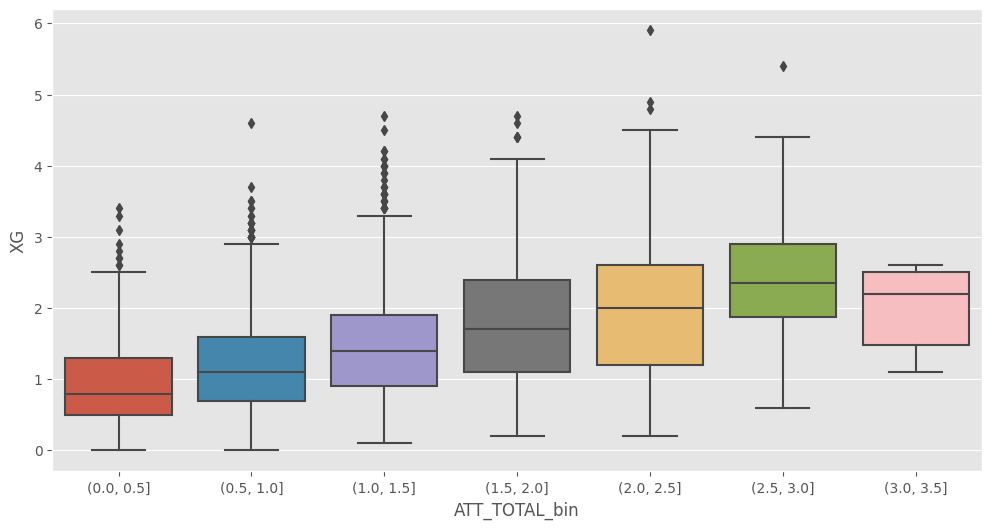

In [5]:
copy_df = processed_data[["ATT_TOTAL", "XG"]].copy()
copy_df['ATT_TOTAL_bin'] = pd.cut(copy_df['ATT_TOTAL'], bins=np.arange(0,4, 0.5))
plt.figure(figsize=(12, 6))
sns.boxplot(x='ATT_TOTAL_bin', y='XG', data=copy_df)
plt.show()

In [6]:
def encode_features(X, categorical_features, numerical_features, encoder):
    X_cat = X[categorical_features]
    X_num = X[numerical_features]

    X_encoded = np.hstack([
        encoder.transform(X_cat).toarray(),
        X_num
    ])
    return X_encoded

In [7]:
numerical_features = ['ROUND', 'POSS', 'DAYS_TILL_NEXT', 'DAYS_SINCE_LAST', 'ATT_TOTAL', 'HOME_ATT_TOTAL', 'AWAY_ATT_TOTAL'] 
# 'DEF_TOTAL', 'HOME_DEF_TOTAL', 'AWAY_DEF_TOTAL', 'DATE', 'XGA', ]
categorical_features = ['VENUE', 'TEAM', 'OPPONENT']
target = "XG"

train_val_data = processed_data[processed_data['SEASON'] < "2021-2022"]
X_train_val = train_val_data[numerical_features+categorical_features]
y_train_val = train_val_data[target]

holdout_data = processed_data[processed_data['SEASON'] >= "2021-2022"]
X_holdout  = holdout_data[numerical_features+categorical_features]
y_holdout  = holdout_data[target]

groups = train_val_data["SEASON"]
n_splits = groups.nunique()
print(f"{groups.unique() = }")
group_kfold = GroupKFold(n_splits=n_splits)

X_train_val_cat = X_train_val[categorical_features]
categories = [np.append(X_train_val_cat[col].unique(), 'Unknown') for col in X_train_val_cat.columns]
encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', categories=categories, min_frequency=1)
encoder.fit(X_train_val_cat)
encoded_cat_cols = encoder.get_feature_names_out(input_features=categorical_features)

model = XGBRegressor(
    base_score=0.5,
    n_estimators=1000,
    early_stopping_rounds=50,
    objective ='reg:squarederror', 
    learning_rate=0.01,
    eval_metric='mae', 
    seed=42
    )

cross_val_scores = []
for train_index, val_index in group_kfold.split(X_train_val, y_train_val, groups):
    X_train_encoded = encode_features(X_train_val.iloc[train_index], categorical_features, numerical_features, encoder)
    X_val_encoded = encode_features(X_train_val.iloc[val_index], categorical_features, numerical_features, encoder)
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_train_encoded, y_train), (X_val_encoded, y_val)],
        verbose=100
        )

    val_predictions = model.predict(X_val_encoded)
    val_accuracy = mean_squared_error(y_val, val_predictions)
    cross_val_scores.append(val_accuracy)


avg_cv_accuracy = sum(cross_val_scores) / n_splits
print(f'Average cross-validation accuracy: {avg_cv_accuracy}')
print(cross_val_scores)

groups.unique() = array(['2017-2018', '2018-2019', '2019-2020', '2020-2021'], dtype=object)
[0]	validation_0-mae:0.86281	validation_1-mae:0.83662
[100]	validation_0-mae:0.52779	validation_1-mae:0.58037
[200]	validation_0-mae:0.45504	validation_1-mae:0.55991
[230]	validation_0-mae:0.44646	validation_1-mae:0.56025
[0]	validation_0-mae:0.83951	validation_1-mae:0.90705
[100]	validation_0-mae:0.52112	validation_1-mae:0.61843
[200]	validation_0-mae:0.45699	validation_1-mae:0.58142
[300]	validation_0-mae:0.43384	validation_1-mae:0.58112
[318]	validation_0-mae:0.43040	validation_1-mae:0.58147
[0]	validation_0-mae:0.84748	validation_1-mae:0.88283
[100]	validation_0-mae:0.52661	validation_1-mae:0.58661
[200]	validation_0-mae:0.46354	validation_1-mae:0.55167
[300]	validation_0-mae:0.44103	validation_1-mae:0.55132
[314]	validation_0-mae:0.43830	validation_1-mae:0.55143
[0]	validation_0-mae:0.87499	validation_1-mae:0.79900
[100]	validation_0-mae:0.53862	validation_1-mae:0.52660
[184]	validation_0-m

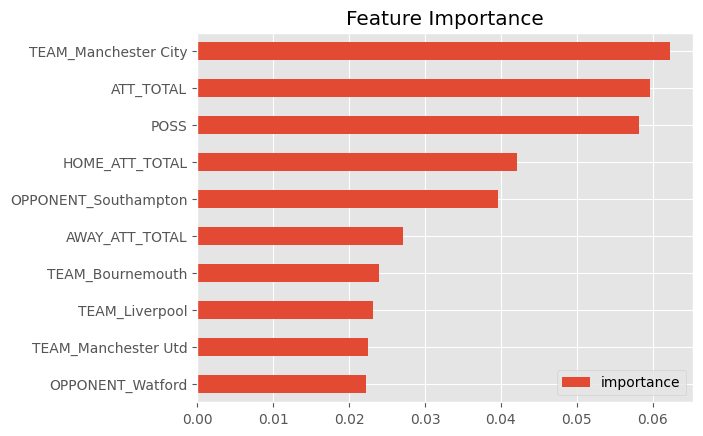

In [8]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=encoded_cat_cols.tolist()+numerical_features,
             columns=['importance'])
fi = fi.sort_values(by='importance', ascending=False).head(10)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

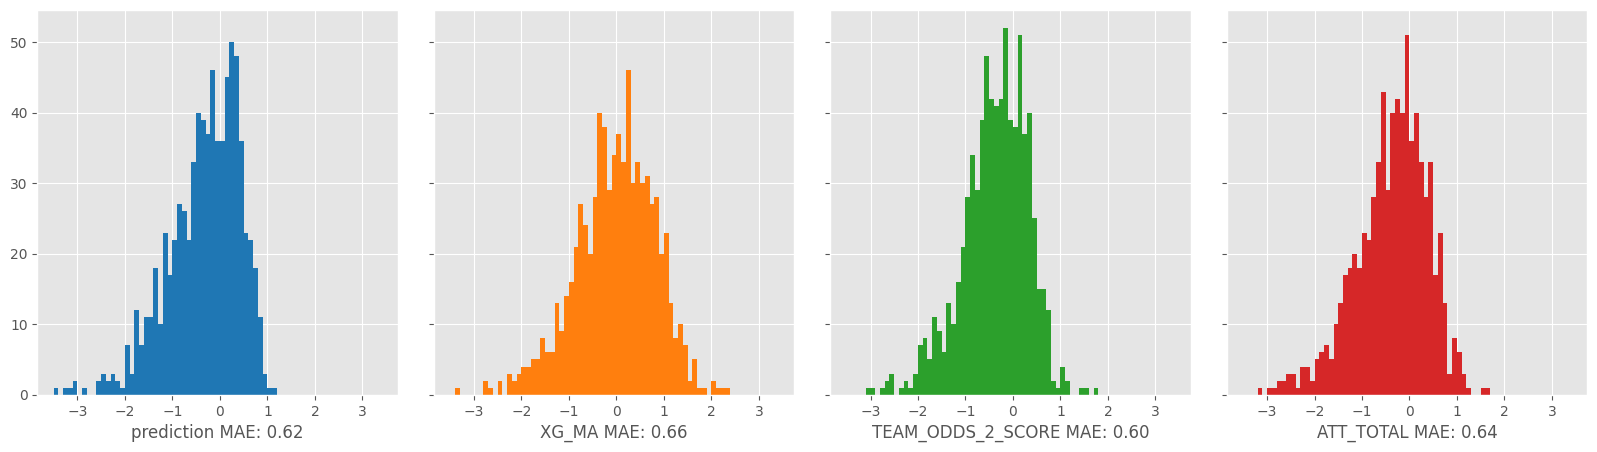

In [9]:
X_holdout_encoded = encode_features(X_holdout, categorical_features, numerical_features, encoder)
holdout_predictions = model.predict(X_holdout_encoded)


baseline_columns = ['XG_MA', "TEAM_ODDS_2_SCORE", 'ATT_TOTAL']
output_cols = list(set(["index"]+numerical_features+categorical_features+[target]+baseline_columns))
output_df = holdout_data[output_cols].copy()
eval_cols = ["prediction"]+baseline_columns
output_df["prediction"] = holdout_predictions

fig, axes = plt.subplots(nrows=1, ncols=len(eval_cols), figsize=(20, 5), sharey=True)

for i, col in enumerate(eval_cols):
    output_df[f"{col}_error"] = output_df[col] - output_df[target]
    output_df[f"{col}_error"].hist(ax=axes[i], bins=np.arange(-3.5, 3.5, 0.1), color=color_pal[i])
    mae = output_df[f"{col}_error"].abs().mean()
    axes[i].set_xlabel(f"{col} MAE: {mae:.2f}")
output_df.head()
plt.subplots_adjust(wspace=0.1)
plt.show()